In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import  torch, os
from    torch import nn
from    torch import optim
import  numpy as np
import data_handler
import trainer
from trainer.cnp import CNP_Trainer
import networks
from copy import deepcopy

# Setting random seeds
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# Setting training configuration
args = {}
args['dataset'] = 'sine'
args['inner_lr'] = 0.01 # We don't use inner_lr in CNP
args['meta_lr'] = 0.001
args['n_way'] = 1 # number of classes or outputs. In sinewave case, n_way is 1
args['k_spt'] = 10 # number of training samples
args['k_qry'] = 10 # number of test samples
args['device'] = torch.device('cpu')
args['tasknum'] = 50
args['epochs'] = 5000
#### IMPORTANT####
args['inner_steps'] = 1 # We don't use inner_steps in CNP

# Dataset (Sine-wave)

In [3]:
dataloader = data_handler.get_dataset(args)

# CNP encoder-decoder network

In [52]:
class EncoderDecoder(nn.Module):
    def __init__(self, ninput=1, noutput=1):
        super(EncoderDecoder, self).__init__()
        
        ##########################################################################################
        
        # Write your code here
        ntotal = ninput + noutput # ntotla=2

        self.fc_enc_1 = nn.Linear(ntotal, 128)
        self.fc_enc_2 = nn.Linear(128, 128)
        self.fc_enc_3 = nn.Linear(128, 128)
        self.fc_enc_4 = nn.Linear(128, 128)

        self.fc_dec_1 = nn.Linear(128+ninput, 128)
        self.fc_dec_2 = nn.Linear(128, 128)
        self.fc_dec_3 = nn.Linear(128, noutput)

        self.relu = nn.ReLU()
        ##########################################################################################
        
        
        
    def forward(self, x_spt, y_spt, x_qry):
        """
        :param x_spt: [tasknum, num_spt, 1]
        :param y_spt: [tasknum, num_spt, 1]
        :param x_qry: [tasknum, num_qry, 1]
        :return: output(encoder==False), representation(encoder==True)
        """
        
        ##########################################################################################
        
        # Write your code here
        input = torch.concat((x_spt, y_spt), dim=-1)
        out = self.relu(self.fc_enc_1(input))
        out = self.relu(self.fc_enc_2(out))
        out = self.relu(self.fc_enc_3(out))
        out = self.fc_enc_4(out)

        representation = out.mean(dim=1, keepdim=True)

        num_qry = x_qry.size()[1]
        tasksum, _, dim = representation.size()
        representation = representation.expand(tasksum, num_qry, dim)

        input = torch.cat((x_qry, representation), dim=-1)
        out = self.relu(self.fc_dec_1(input))
        out = self.relu(self.fc_dec_2(out))
        out = self.fc_dec_3(out)

        return out
        ##########################################################################################
        
        


In [53]:
# Initialize network
myModel = EncoderDecoder(1,1).to(args['device'])

# Train CNP

In [54]:
CNP = CNP_Trainer(myModel, args)
CNP.train(dataloader, args['epochs'])

step: 0 	training loss: [3.6413280963897705]
Test loss: [4.22]
step: 50 	training loss: [3.313624620437622]
step: 100 	training loss: [2.1759297847747803]
step: 150 	training loss: [0.702741801738739]
step: 200 	training loss: [0.8347388505935669]
step: 250 	training loss: [0.6952389478683472]
step: 300 	training loss: [0.5623589158058167]
step: 350 	training loss: [0.43699273467063904]
step: 400 	training loss: [0.4333374500274658]
step: 450 	training loss: [0.44833073019981384]
step: 500 	training loss: [0.42888879776000977]
Test loss: [0.3657]
step: 550 	training loss: [0.2586631774902344]
step: 600 	training loss: [0.31789183616638184]
step: 650 	training loss: [0.27794149518013]
step: 700 	training loss: [0.24103181064128876]
step: 750 	training loss: [0.27495038509368896]
step: 800 	training loss: [0.23126238584518433]
step: 850 	training loss: [0.2611790597438812]
step: 900 	training loss: [0.2454393357038498]
step: 950 	training loss: [0.19738255441188812]
step: 1000 	training 

# Evaluate the performance
## 1. Plot ground truth function & support set

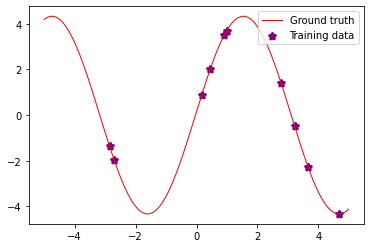

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

amplitude = np.random.uniform(0.1, 5)
phase = np.random.uniform(0, np.pi)

x = np.arange(1000) / 1000 * (10) - 5
y = np.sin(x + phase) * amplitude

x_qry = np.random.rand(10) * 10 - 5
y_qry = np.sin(x_qry + phase) * amplitude

plt.plot(x, y, color='red', linestyle='-', label='Ground truth', linewidth=1)
plt.scatter(x_qry, y_qry, color='purple', linestyle='-', label='Training data', linewidth=3, marker = '*')

plt.legend()

## 2. Plot adapted function

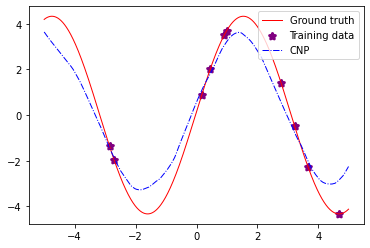

In [56]:
x_reshape = np.array(x).astype(np.float32).reshape(1, 1000, 1)
y_reshape = np.array(y).astype(np.float32).reshape(1, 1000, 1)

x_tensor = torch.from_numpy(x_reshape).to(args['device'])
y_tensor = torch.from_numpy(y_reshape).to(args['device'])

x_qry_reshape = np.array(x_qry).astype(np.float32).reshape(1, 10, 1)
y_qry_reshape = np.array(y_qry).astype(np.float32).reshape(1, 10, 1)

x_qry_tensor = torch.from_numpy(x_qry_reshape).to(args['device'])
y_qry_tensor = torch.from_numpy(y_qry_reshape).to(args['device'])

# Fast adaptation
y_pred_after = myModel(x_qry_tensor, y_qry_tensor, x_tensor).squeeze()

plt.plot(x, y, color='red', linestyle='-', label='Ground truth', linewidth=1)
plt.scatter(x_qry, y_qry, color='purple', linestyle='-', label='Training data', linewidth=3, marker = '*')
plt.plot(x, y_pred_after.detach().cpu().numpy(), color='blue', linestyle='-.', label='CNP', linewidth=1)

plt.legend()